## RMF EOS inference pipeline

This is an example notebook about how to use our tools to analysis a observation/nuclear constraint on neutron star equation of stat. 

Here in this notebook, we are using a RMF EoS model

In [ ]:
#Package we need:
import InferenceWorkflow.BayesianSampler as sampler
import InferenceWorkflow.Likelihood as likelihood
import InferenceWorkflow.prior as prior
import math
import numpy as np

from TOVsolver.constant import oneoverfm_MeV, m_rho, m_w,G,c
import TOVsolver.main as main
import EOSgenerators.crust_EOS as crust
import EOSgenerators.fastRMF_EoS as RMF

We need to define the crust, this crust and interface is unversial for all the equation of state here, we just change the core part of equation of state and that is come from the RMF computation. Crust as below, "Tolos_crust_out.txt" is BPS crust model. Then as in README, since that file energy_density and presurssure all in MeV/fm3, so we need some conversion. then just call 

   ```sh
   crust.PolyInterpolate
   ```

To finish the interface and make it ready to connect with core part

In [ ]:
#Tolos_crust_out = np.loadtxt('Tolos_crust_out.txt', delimiter='  ')
Tolos_crust_out = np.loadtxt('Tolos_crust_out.txt', delimiter=None, comments='#', usecols=(0, 1, 2, 3, 4))
eps_crust_out = Tolos_crust_out[:,3] * G / c**2
pres_crust_out = Tolos_crust_out[:,4] * G / c**4

eps_crust, pres_crust = crust.PolyInterpolate(eps_crust_out, pres_crust_out)


### Set up prior

Next step, we need to set up the prior, first use parameters array to specify the variable name, should consistent with what you need to call them.

Define a prior transform function to define prior. Cube are set of random number from 0 to 1. This prior setting is standard set-up of UltraNest package, since we are using UltraNest to do nest-sampling. We provided 

"normal_Prior" and "flat_prior"

two options call from prior. Here then the Parameters prior should all set

------------------

However, since we are doing Equation of state Inference from mass radius of neutron star measurement. The center density of the star should be also sampled. Otherwise will be a partially-defined prior, did not span all parameters space, and proved to be different with full-scope inference.

This request as randomly generate a density from a EoS range, however, this process is not that trivial, since we need to determine the upper limit of the central density of neutron star ---  different equation of state will predict different upper bound, so here we need to use the prior-setting EoS parameters computing the EOS by

```sh
RMF.compute_EOS
```

Compute out EOS, put into

```sh
main.OutputMR
```

find out Mass Radius of this equation of state, find out the last stable point of this equation of state.(first mass points that give the direvative to be negative)

found out that index by len() function, then reset this max_d to be upper limit of this density range.

In [ ]:
parameters = ['g_sigma', 'g_omega','g_rho', 'kappa', 'lambda_0', 'zeta', 'Lambda_w','d1']
# for two or more MR measurements, define d2 or more depend on complexity.
# parameters = ['g_sigma', 'g_omega','g_rho', 'kappa', 'lambda_0', 'zeta', 'Lambda_w','d1', 'd2']

def prior_transform(cube):
    params = cube.copy()
    params[0] = math.sqrt(prior.normal_Prior(107.5, 7.5,cube[0]))
    params[2] = math.sqrt(prior.flat_prior(75,210,cube[2]))
    params[1] = math.sqrt(prior.flat_prior(150,210,cube[1]))
    params[3] = prior.normal_Prior(2.525/oneoverfm_MeV, 1.525/oneoverfm_MeV,cube[3])
    params[4] = prior.normal_Prior(0.0045, 0.0205,cube[4])
    params[5] = prior.flat_prior(0,0.04,cube[5])
    params[6] = prior.flat_prior(0,0.045,cube[6])
    
    g_sigma = params[0]
    g_omega = params[1]
    g_rho = params[2]

    kappa = params[3]
    lambda_0 = params[4]
    zeta = params[5]
    Lambda_w = params[6]
    m_sig = 495 / oneoverfm_MeV

    theta = np.array([m_sig, m_w, m_rho, g_sigma, g_omega, g_rho, kappa,
                         lambda_0, zeta, Lambda_w])
    
    ep, pr = RMF.compute_EOS(eps_crust, pres_crust, theta)

    eps_total = np.hstack((eps_crust,ep))
    
    pres_total = np.hstack((pres_crust,pr))
    
    RFSU2R = []
    MFSU2R = []
    density = np.logspace(14.3, 15.6, 50)
    if all(x<y for x,y in zip(eps_total[:], eps_total[1:])) and all(x<y for x, y in zip(pres_total[:], pres_total[1:])):
        MR = main.OutputMR('',eps_total,pres_total).T
        if len(MR[1]) == False: 
            params[7] = 0
            #params[8] = 0
            # this line for showing how to add one more observation
        else:
   
            for i in range(len(MR[1])):
                RFSU2R.append(MR[0][i])
                MFSU2R.append(MR[1][i])   
                if i > 20 and MR[1][i] - MR[1][i-1]< 0:
                    break
    if len(MFSU2R)==False:
        params[7] = 0
        # params[8] = 0
        # this line for showing how to add one more observation
    else:
        max_index = len(MFSU2R)
        max_d = np.log10(density[max_index-1])
        params[7] = 14.3 + (max_d - 14.3) * cube[7]
        # params[8] = 14.3 + (max_d - 14.3) * cube[8]
        # this line for showing how to add one more observation
    return params

### Set up likelihood

We need to set up a likelihood, Using standard definition way of UltraNest, that is below.

Here the likelihood is generated from a simulated mass radius measurement, which is $M = 1.4 M_{\odot}$ and $R = 13$ km, With a 5% Mass radius measurement uncertainty, so here 

   ```sh
   likelihood.MRlikihood_Gaussian
   ```
function will be use for our likelihood, please check [likelihood.MRlikihood_Gaussian](https://github.com/ChunHuangPhy/EoS_inference/blob/main/InferenceWorkflow/Likelihood.py) to see the original code, and more choice of likelihood.
eg:
1. If we have some real mass-radius measurements, say PSR J0030 or PSR J0740, come from NICER, a KDE kernel could be trained to feed into 

   ```sh
   likelihood.MRlikihood_kernel(eps_total,pres_total,x,d1)
   ```
set the KDE kernel as a input for this function

2. If we gain measurement from radio-timing, say only measure the neutron star mass, then

   ```sh
   likelihood.Masslikihood_Gaussian(eps_total,pres_total,x,d1)
   ```
Which will give the likelihood from single mass measurement, x is the parameters of that measurement, you should specify where this measurement mass is located and what is the sigma width of this mass measurement

3. If we have nuclear measurements, and want to constrain this RMF model by nuclear properties like K(The Incompressibility of nuclear matter),J ( the symmetry energy at saturation density) and L( the slope of symmetry energy at saturation density). You can choose:

   ```sh
   likelihood.Kliklihood(theta,K_low,K_up)
   likelihood.Jliklihood(theta,K_low,K_up)
   likelihood.Lliklihood(theta,K_low,K_up)
   ```
We are defaulting a hard-cut flat constrain, so if you don't like this default hard cut, also could define the likelihood by youself with similiar style.

4. If we have a Tidal measurements from Gravitational wave detector, we can use it to do constraint:

   ```sh
   likelihood.TidalLikihood_kernel(eps_total,pres_total,x,d1)
   ```
Where x is sampled distribution from real measurements, the standard is 

kernel, chrip = x, 

where the kernel is a whole set sampling from GW event, that is  [chrip mass, M2/M1, tidal of M1, tidal of M2] four quantities. Chrip is the single smapling that comes only the chrip mass sampling.



5. To calculate the log-likelihood for the pure neutron matter (PNM) equation of state (EoS) using chiral effective field theory (chiEFT) constraints, the function
   
     `likelihood.chiEFT_PNM(EoS_PNM, type="Gaussian", contraint_quantity="e", enlargement=0)`

EoS_PNM is a 3D array of number density (rho), energy density (e) and pressure (p) with unit fm^-3, MeV.fm^-3 and MeV.fm^-3.  

compares PNM EoS data with chiEFT-derived constraints for either energy per neutron \( E/N \) or pressure \( p \),
depending on the specified `contraint_quantity` parameter ("e" for energy or "p" for pressure). 

The likelihood model can be either "Gaussian" or "Super Gaussian" with an optional `enlargement` factor for the Super Gaussian to flatten its peak. e.g., 0.05 for 5% enlargement. 

The function calculates the sum of log-likelihoods over densities of 0.08, 0.12, and 0.16 fm\(^-3\), utilizing energy constraints from Huth et al. (Nature, 2022) and pressure constraints from Hebeler et al. (ApJ, 2013). This enables a statistical comparison of the PNM EoS data against chiEFT-derived reference values.

In [ ]:
import scipy.stats as stats
def likelihood_transform(theta):
    # This is a demonstration code for only introduce one constraint from one mass-radius observation.
    # Could be very easy to implement more constraint from nuclear quantity, since that do not need to
    # sample more central density of real neutron star. If user want to expand to two mass radius measurement 
    # the code could be:
    
    # g_sigma, g_omega,g_rho, kappa, lambda_0, zeta, Lambda_w, d1, d2 = theta
    g_sigma, g_omega,g_rho, kappa, lambda_0, zeta, Lambda_w, d1 = theta # comment this line if you need two measuremnts.
    
    ####################################################################################################################
    ############ This is the block to compute out all the EoS you need based on your parameters#########################
    m_sig = 495 / oneoverfm_MeV
    m_w = 3.96544
    m_rho = 3.86662
    theta1 = np.array([m_sig, m_w, m_rho, g_sigma, g_omega, g_rho, kappa, lambda_0, zeta, Lambda_w])
    ep, pr = RMF.compute_EOS(eps_crust, pres_crust, theta1)

    eps_total = np.hstack((eps_crust,ep))
    pres_total = np.hstack((pres_crust,pr))
    ####################################################################################################################
    
    # probMRgaussian1 = likelihood.MRlikihood_Gaussian(eps_total,pres_total,(1.4,13,0.07,0.65),d1)
    # probMRgaussian2 = likelihood.MRlikihood_Gaussian(eps_total,pres_total,(2.0,12,0.1,0.6),d2)
    # probMR = probMRgaussian1 + probMRgaussian2
    
    # Same could be extended to more distributions. Notice the prior definition should be change accordingly
    # by define more density parameters like here d2.
    
    #1. This line is to compute MR likelihood from a Simulated MR measurement:
    
    
    probMRgaussian = likelihood.MRlikihood_Gaussian(eps_total,pres_total,(1.4,13,0.07,0.65),d1)
    
    #2. This is  a block that constrain from given real MR measurement, say J0030:
    #J0030 = numpy.loadtxt('data/PST_equal_sampled_MR.txt', delimiter=' ')
    #J30R_list, J30M_list = zip(*J0030)
    #J30R_list = numpy.array(J30R_list).T    
    #J30M_list = numpy.array(J30M_list).T
    #Rmin = J30R_list.min()
    #Rmax = J30R_list.max()
    #Mmin = J30M_list.min()
    #Mmax = J30M_list.max()
    #X3, Y3 = numpy.mgrid[Rmin:Rmax:500j, Mmin:Mmax:100j]
    #positions = numpy.vstack([X3.ravel(), Y3.ravel()])
    #values = numpy.vstack([J30R_list, J30M_list])
    #kernel3 = stats.gaussian_kde(values)
    #probMRJ0030 = likelihood.MRlikelihhood_kernel(eps_total,pres_total,kernel3,d1)
    
    #3. This is to compute the constraint from experiment of nuclearmatter
    # 250<K<400, 25<J<38, 30<L<86:
    # hint: since this K,J,L sampling don't need to sample central density so this 
    # theta should be redifined.
    #probK = likelihood.Kliklihood(theta,250,400)
    #probJ = likelihood.Jliklihood(theta,250,400)
    #probL = likelihood.Lliklihood(theta,250,400)
    
    #4. This is block to cosntrain from a GW event, say GW170817, here the file of this
    # event is origanized by [chrip mass, M2/M1, tidal of M1, tidal of M2, sampling weight]:
    #GW170817 = np.load('GW170817_McQL1L2weights.npy')
    #chrip170817 = stats.gaussian_kde(GW170817[:,0],weights = GW170817[:,4])
    #kernelGW = stats.gaussian_kde(GW170817.T[0:4],weights = GW170817[:,4])
    #probGW = likelihood.TidalLikihood_kernel(eps_total,pres_total,(kernelGW,chrip170817),d1)


    #5. This block constraints pure neutron matter EOS
    ## For pure neutron matter alpha = 0
    #theta1    = np.append(theta, 0)
    #rho, e, p = RMF.get_eos_alpha(theta1)
    #EoS_PNM   = np.array([rho, e*oneoverfm_MeV, p*oneoverfm_MeV]) # energy density and pressure are converted from fm^-4 to MeV fm^-3
 
    #probPNM = likelihood.chiEFT_PNM(EoS_PNM, type="Super Gaussian", contraint_quantity="e", enlargement=0.1) # 10% enlargement 

    prob =  probMRgaussian #+ probMRJ0030 + probK + probJ + probL + probGW + probPNM 
    return prob

### Set up sampler

Here next, we define sampler, there is two different sampler we provided for. Considering where you need resume file:

```sh
sampler.UltranestSampler   and  sampler.UltranestSamplerResume
```

Here since it is our first run, so we only use first one. some of the sampler parameters is requested, first is step number, our choice for UltraNest sampler is slicesampler, which could easily be sliced up your total computation load, and parallelize, speed up sampling. So step as suggested by documentation of UltraNest, we use 2*len(parameters).

live_point we set 2000, it will influence the sampling precision, We suggest for 7 dimension space, maybe 5000 is a better choice, however, since my computer only have limited resources, we set 2000.

max_calls set 10000, it is how many iteration after it will stop, we suggest to set this number significantly higher, otherwise maybe will broken before the inference converging to a definite value. That result will be un-phyiscal


In [ ]:
step = 2 * len(parameters)
live_point = 2000

max_calls = 60000
samples = sampler.UltranestSampler(parameters,likelihood_transform,prior_transform,step,live_point,max_calls)


### Posterior plot
Since we only run our code at my labtob so here is the result corner plot(still have a lot flucatuation)

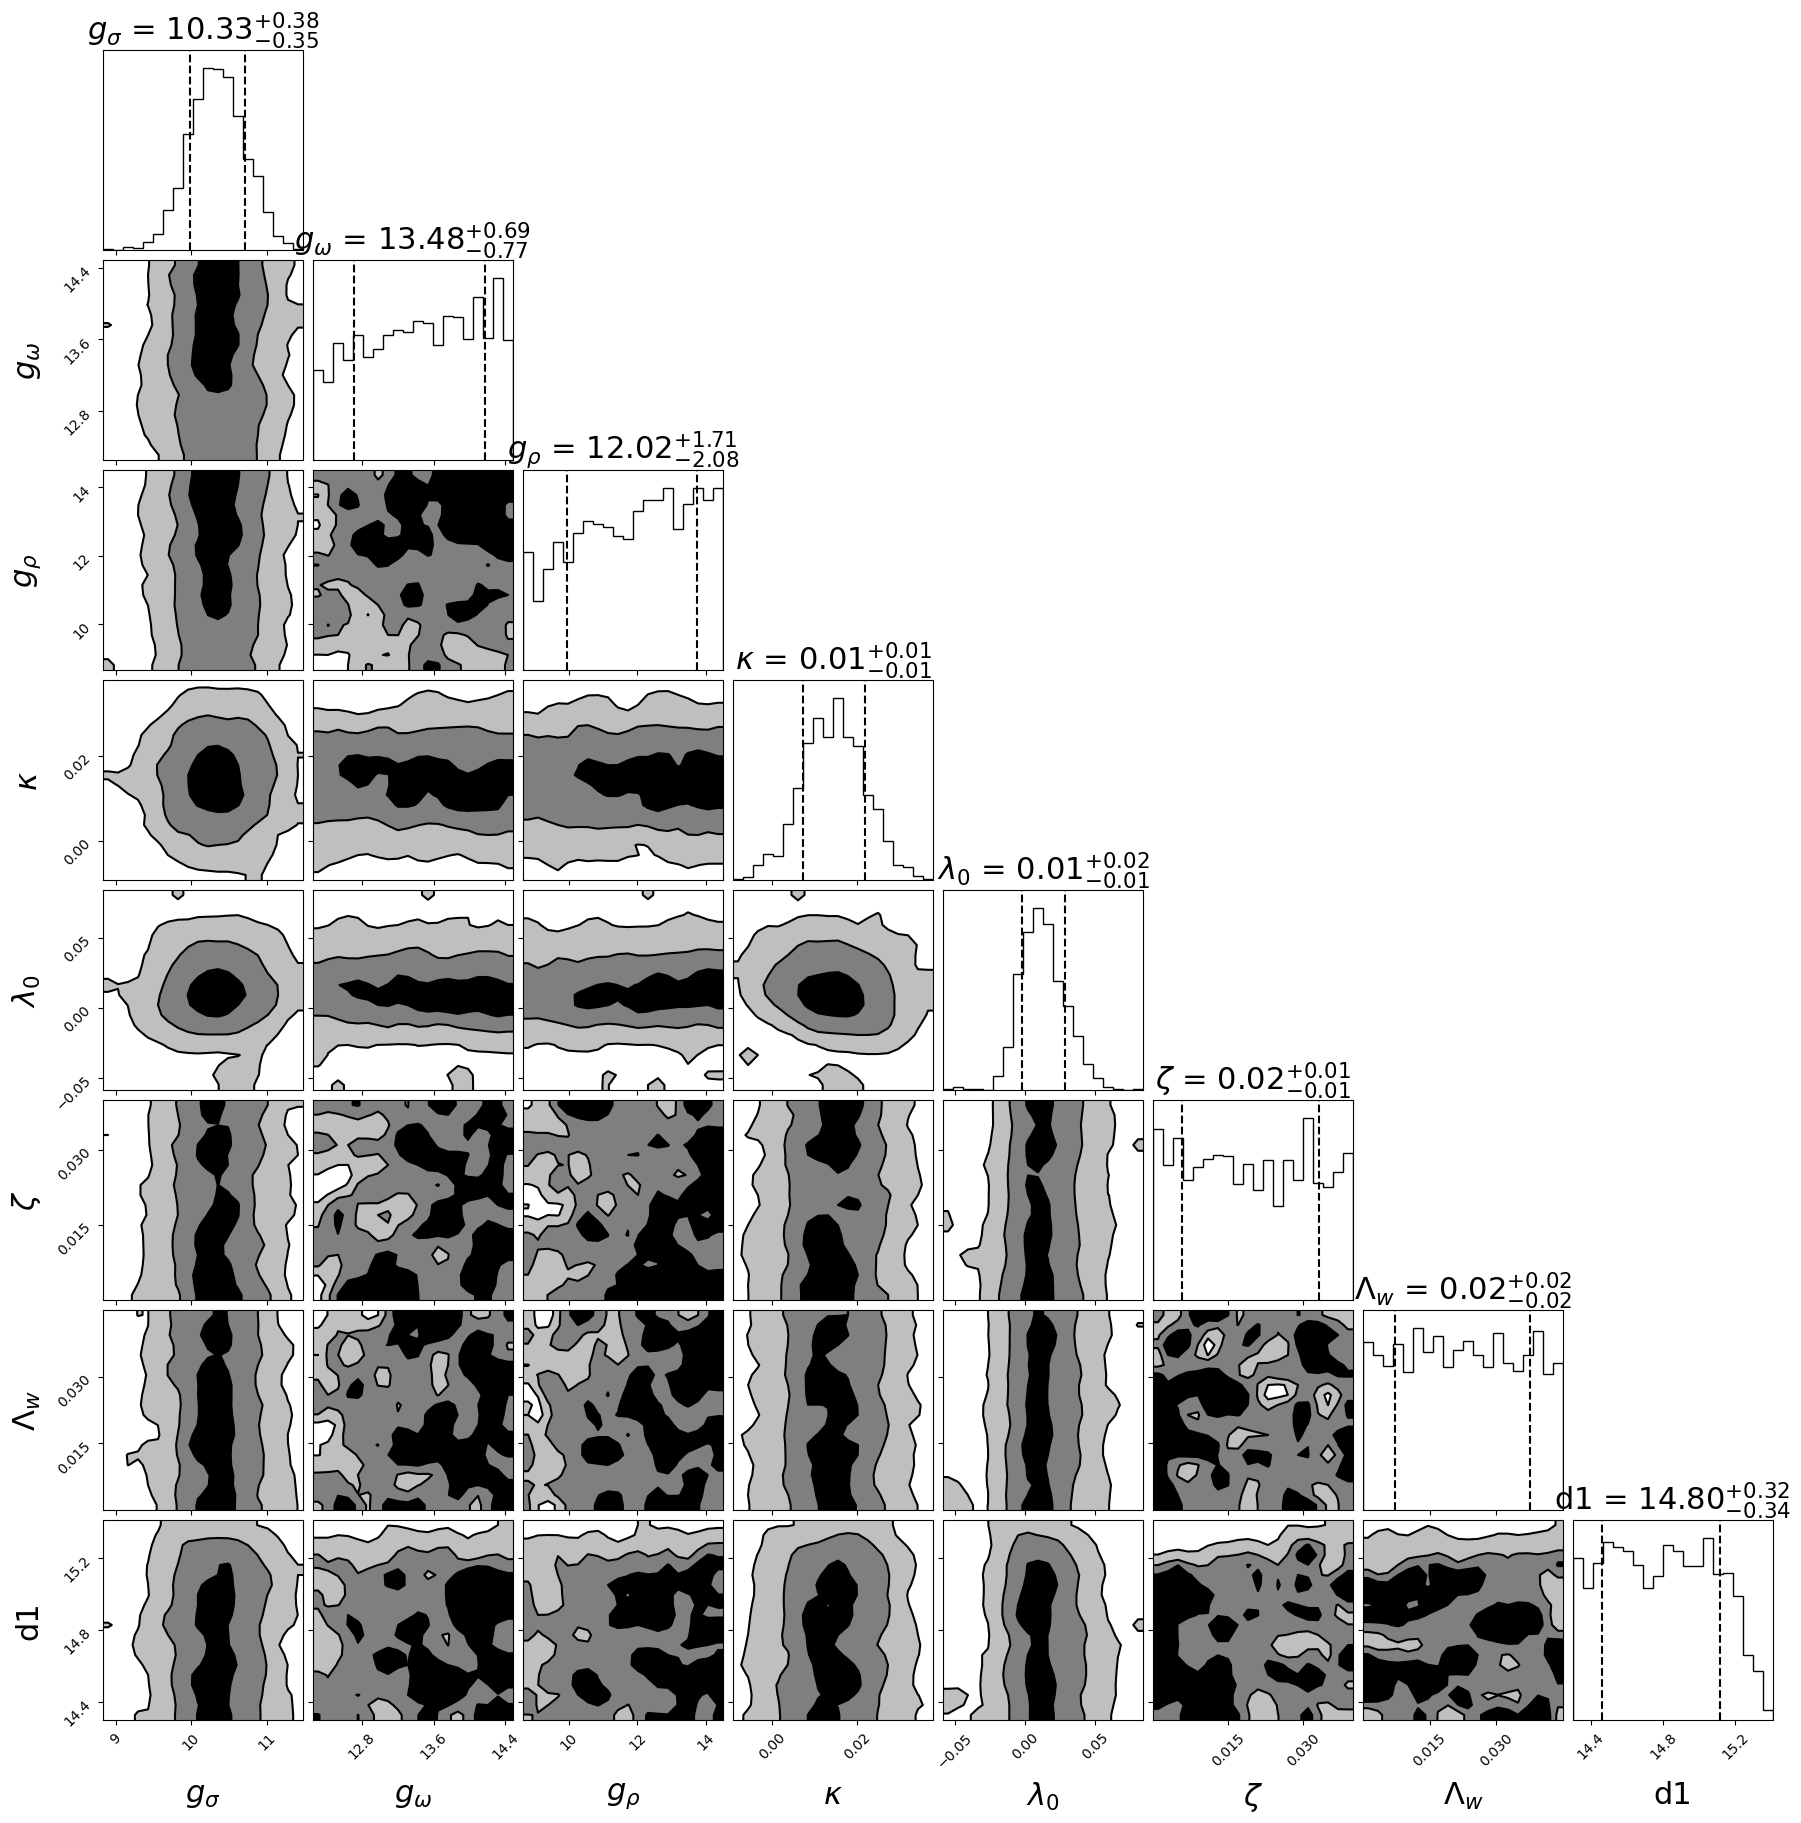

In [ ]:
import corner

figure = corner.corner(samples,labels=[ r"$g_{\sigma}$", r"$g_{\omega}$",r"$g_{\rho}$",r"$\kappa$", r"$\lambda_0$",r"$\zeta$",r"$\Lambda_w$","d1","d2"],
                    smooth=0.9,
                    label_kwargs=dict(fontsize=22),
                    title_kwargs=dict(fontsize=22),
                    quantiles=[0.16, 0.84],
                    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                    plot_density=False,
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    max_n_ticks=3,
                    title_fmt= '.2f')
                       #,range=[(10,80),(0.56,0.64),(0.10, 0.2),(150,600),(40,80),(50,75)])